In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import corner

from tqdm.auto import tqdm


In [2]:
from haloflow.config import setup_plotting_config
setup_plotting_config()

In [3]:
from haloflow import data as D
from haloflow.util import read_best_ndes, bias_estimate
from haloflow.corr import weight_nde
from haloflow.npe import plotting as P

In [4]:
import pickle
with open('bias_estimate_results_new.pkl', 'rb') as f:
    results = pickle.load(f)

In [5]:
rng = np.random.default_rng(42)

In [6]:
hm_bins = np.linspace(11.5, 14.1, 10)
hm_bin_centers = 0.5 * (hm_bins[1:] + hm_bins[:-1])

sm_bins = np.arange(10, 12.1, 0.5)
sm_bin_centers = 0.5 * (sm_bins[1:] + sm_bins[:-1])

In [7]:
y_SIMBA, _ = D.hf2_centrals('test', 'mags', sim='Simba100', version=1)
sm_SIMBA = y_SIMBA[:, 0]
hm_SIMBA = y_SIMBA[:, 1]

median_sm_SIMBA = []
std_hm_SIMBA = []

for lo, hi in zip(hm_bins[:-1], hm_bins[1:]):
    in_bin = (hm_SIMBA >= lo) & (hm_SIMBA < hi)
    median_sm_SIMBA.append(np.median(sm_SIMBA[in_bin]))


for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (sm_SIMBA >= lo) & (sm_SIMBA < hi)
    std_hm_SIMBA.append(np.std(hm_SIMBA[in_bin]))
std_hm_SIMBA = np.array(std_hm_SIMBA)

In [8]:
y_EAGLE, X_EAGLE = D.hf2_centrals('test', 'mags', sim='Eagle100', version=1)
sm_EAGLE = y_EAGLE[:, 0]
hm_EAGLE = y_EAGLE[:, 1]

median_sm_EAGLE = []

for lo, hi in zip(hm_bins[:-1], hm_bins[1:]):
    in_bin = (hm_EAGLE >= lo) & (hm_EAGLE < hi)
    median_sm_EAGLE.append(np.median(sm_EAGLE[in_bin]))

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
# find one EAGLE galaxy at log M* of 10.75
sample_galaxy = np.argmin(np.abs(sm_EAGLE - 10.75))
sample_hm = hm_EAGLE[sample_galaxy]
sample_sm = sm_EAGLE[sample_galaxy]

(10.0, 12.0)

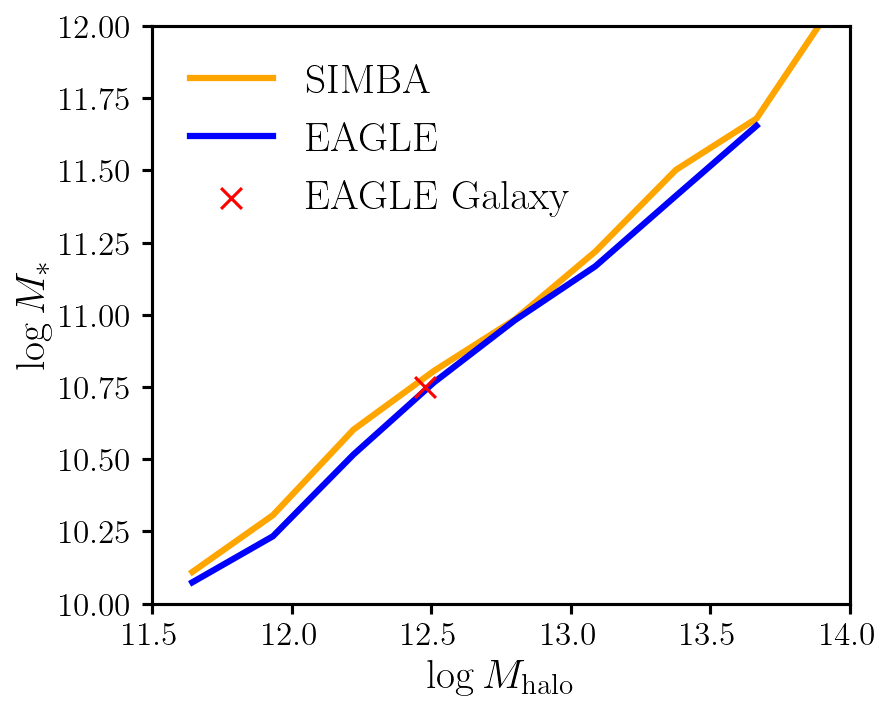

In [10]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.plot(hm_bin_centers, median_sm_SIMBA, label='SIMBA', lw=3, color='orange')
ax.plot(hm_bin_centers, median_sm_EAGLE, label='EAGLE', lw=3, color='blue')

# plot a scatter x at the sample galaxy
ax.scatter(sample_hm, sample_sm, color='red', s=100, marker='x', label='EAGLE Galaxy', zorder=5)

ax.set_xlabel(r'$\log M_\mathrm{halo}$')
ax.set_ylabel(r'$\log M_*$')
ax.legend()

ax.set_xlim(11.5, 14)
ax.set_ylim(10, 12)

In [11]:
# load SIMBA NPE (only mags)
qphis = read_best_ndes(
            'h2.v1.Simba100.mags',
            n_ensemble=5, device='cpu',
            dat_dir='../../data/hf2/npe', verbose=True)

n_samples = 1000

Y_test_torch = torch.tensor(y_EAGLE, dtype=torch.float32, device='cpu')
X_test_torch = torch.tensor(X_EAGLE, dtype=torch.float32, device='cpu')

# Pre-allocate memory
num_test_samples = len(Y_test_torch)
ranks = np.empty((num_test_samples, Y_test_torch.shape[1]), dtype=np.float32)
y_nde_Eagle_mags = np.empty((num_test_samples, n_samples, Y_test_torch.shape[1]), dtype=np.float32)

# Sample in batches to optimize performance
with tqdm(total=num_test_samples, desc="Validating NPE") as pbar:
    for i in range(num_test_samples):
        y_samp = torch.cat([
            qphi.sample((n_samples // len(qphis),), x=X_test_torch[i], show_progress_bars=False)
            for qphi in qphis
        ], dim=0)  # Collect all samples at once

        # Compute ranks in a vectorized way
        ranks[i] = (y_samp < Y_test_torch[i]).float().mean(dim=0).cpu().numpy()

        # Store samples efficiently
        y_nde_Eagle_mags[i] = y_samp.cpu().numpy()
        pbar.update(1)

# weight the nde samples
y_nde_Eagle_mags = weight_nde(y_nde_Eagle_mags, 'Eagle100')

# get the posterior median and 1-sigma intervals
y_nde_Eagle_q0, y_nde_Eagle_q1, y_nde_Eagle_q2 = np.quantile(y_nde_Eagle_mags, [0.16, 0.5, 0.84], axis=1)

1005 models trained
[594, 316, 732, 978, 915]


Validating NPE:   0%|          | 0/889 [00:00<?, ?it/s]

Resampling:   0%|          | 0/889 [00:00<?, ?it/s]

/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:50: UserWarning: some M* samples are below or above the Mh limit
  warnings.warn('some M* samples are below or above the Mh limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:50: UserWarning: some M* samples are below or above the Mh limit
  warnings.warn('some M* samples are below or above the Mh limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astro

In [12]:
print("Precision Metric (NDE only): ",
      np.median(0.5 * (y_nde_Eagle_q2[:, 1] - y_nde_Eagle_q0[:, 1])), " dex")

Precision Metric (NDE only):  0.24434629440307631  dex


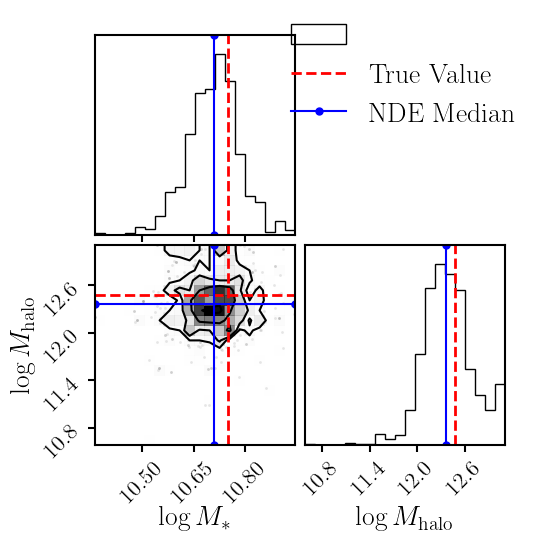

In [13]:
fig = corner.corner(y_nde_Eagle_mags[sample_galaxy], labels=[r'$\log M_*$', r'$\log M_\mathrm{halo}$'])
corner.overplot_lines(fig, [sample_sm, sample_hm], color='red', lw=2, ls='--', label='True Value')
corner.overplot_lines(fig, [y_nde_Eagle_q1[sample_galaxy, 0], y_nde_Eagle_q1[sample_galaxy, 1]], color='blue', marker='o', ms=5, label='NDE Median')
fig.legend([None, 'True Value', 'NDE Median'])

(10.0, 12.0)

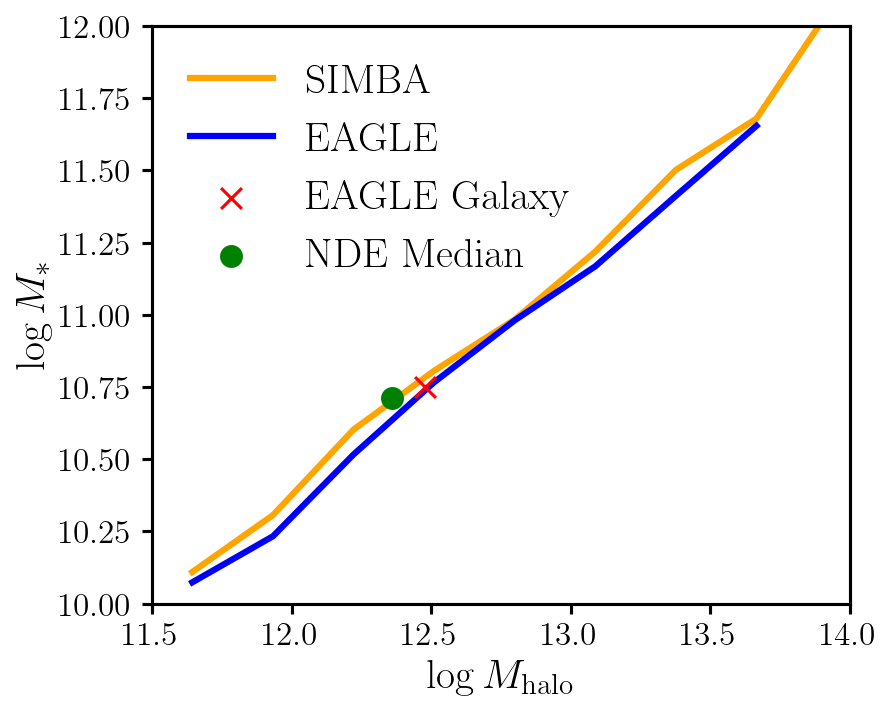

In [14]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.plot(hm_bin_centers, median_sm_SIMBA, label='SIMBA', lw=3, color='orange')
ax.plot(hm_bin_centers, median_sm_EAGLE, label='EAGLE', lw=3, color='blue')

# plot a scatter x at the sample galaxy
ax.scatter(sample_hm, sample_sm, color='red', s=100, marker='x', label='EAGLE Galaxy', zorder=5)

# add NDE median prediction for the sample galaxy
ax.scatter(y_nde_Eagle_q1[sample_galaxy, 1], y_nde_Eagle_q1[sample_galaxy, 0], color='green', s=100, marker='o', label='NDE Median', zorder=5)

ax.set_xlabel(r'$\log M_\mathrm{halo}$')
ax.set_ylabel(r'$\log M_*$')
ax.legend()

ax.set_xlim(11.5, 14)
ax.set_ylim(10, 12)

In [15]:
sm_nde_EAGLE = y_nde_Eagle_mags[:, :, 0]
print(sm_nde_EAGLE.shape)

# see which bin each sample falls into
sm_bin_indices = np.digitize(sm_nde_EAGLE, sm_bins) - 1
sm_bin_indices = np.clip(sm_bin_indices, 0, len(sm_bin_centers) - 1)
print(sm_nde_EAGLE[0, 0], sm_bin_indices[0, 0])

# get hm from SIMBA SMHR
hm_SIMBA_SMHR_EAGLE = np.interp(sm_nde_EAGLE, median_sm_SIMBA, hm_bin_centers)
print(hm_SIMBA_SMHR_EAGLE.shape)

hm_SIMBA_SMHR_EAGLE = hm_SIMBA_SMHR_EAGLE + rng.normal(0.0, std_hm_SIMBA[sm_bin_indices], size=sm_nde_EAGLE.shape)

# get the posterior median and 1-sigma intervals
y_nde_Eagle_SMHR_q0, y_nde_Eagle_SMHR_q1, y_nde_Eagle_SMHR_q2 = np.quantile(hm_SIMBA_SMHR_EAGLE, [0.16, 0.5, 0.84], axis=1)

(889, 1000)
11.120058 2
(889, 1000)


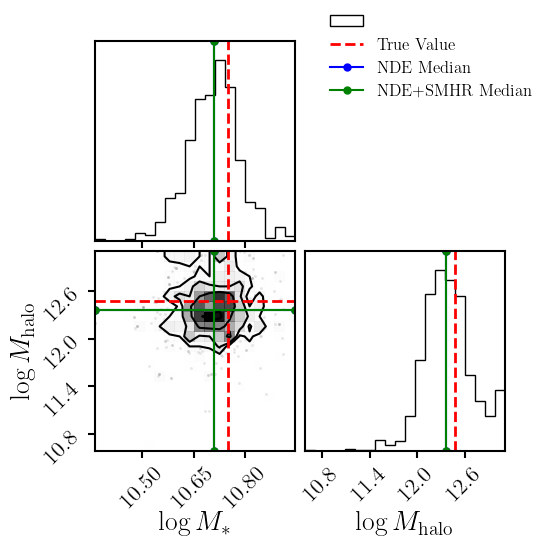

In [16]:
fig = corner.corner(y_nde_Eagle_mags[sample_galaxy], labels=[r'$\log M_*$', r'$\log M_\mathrm{halo}$'], figsize=(6, 6), dpi=300)
corner.overplot_lines(fig, [sample_sm, sample_hm], color='red', lw=2, ls='--', label='True Value')
corner.overplot_lines(fig, [y_nde_Eagle_q1[sample_galaxy, 0], y_nde_Eagle_q1[sample_galaxy, 1]], color='blue', marker='o', ms=5, label='NDE Median')
corner.overplot_lines(fig, [y_nde_Eagle_q1[sample_galaxy, 0], y_nde_Eagle_SMHR_q1[sample_galaxy]], color='green', marker='o', ms=5, label='NDE+SMHR Median')
fig.legend([None, 'True Value', 'NDE Median', 'NDE+SMHR Median'], loc='upper right', fontsize=12)

(10.0, 12.0)

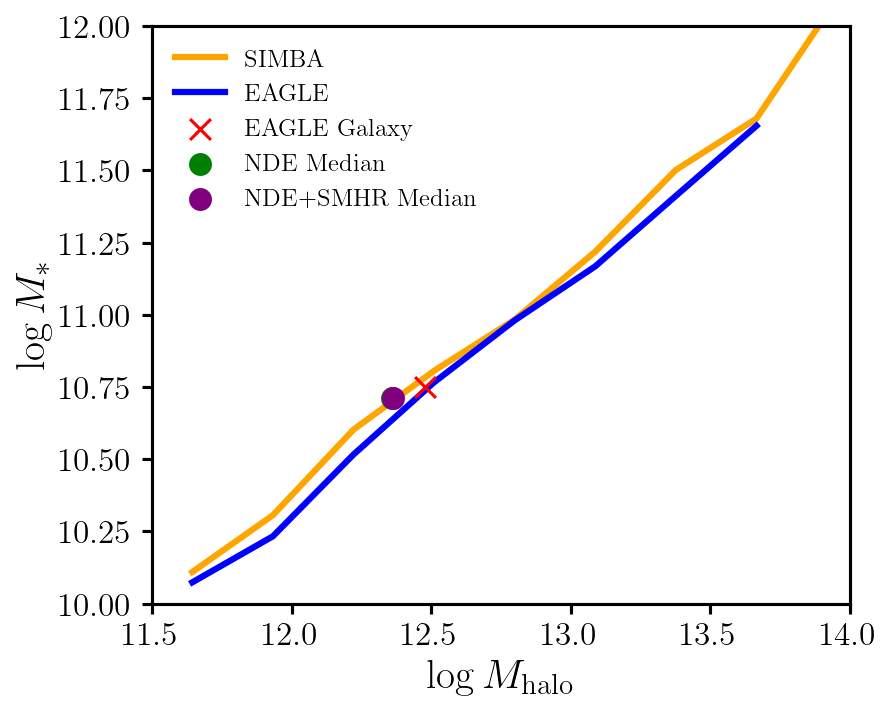

In [17]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.plot(hm_bin_centers, median_sm_SIMBA, label='SIMBA', lw=3, color='orange')
ax.plot(hm_bin_centers, median_sm_EAGLE, label='EAGLE', lw=3, color='blue')

# plot a scatter x at the sample galaxy
ax.scatter(sample_hm, sample_sm, color='red', s=100, marker='x', label='EAGLE Galaxy', zorder=5)

# add NDE median prediction for the sample galaxy
ax.scatter(y_nde_Eagle_q1[sample_galaxy, 1], y_nde_Eagle_q1[sample_galaxy, 0], color='green', s=100, marker='o', label='NDE Median', zorder=5)

# add NDE+SMHR median prediction for the sample galaxy
ax.scatter(y_nde_Eagle_SMHR_q1[sample_galaxy], y_nde_Eagle_q1[sample_galaxy, 0], color='purple', s=100, marker='o', label='NDE+SMHR Median', zorder=5)

ax.set_xlabel(r'$\log M_\mathrm{halo}$')
ax.set_ylabel(r'$\log M_*$')
ax.legend(fontsize=12)

ax.set_xlim(11.5, 14)
ax.set_ylim(10, 12)

In [18]:
# np.median(bias_estimate(y_EAGLE[:, 1], y_nde_Eagle_SMHR_q1, 0.5 * (y_nde_Eagle_SMHR_q2 - y_nde_Eagle_SMHR_q0)))

# calcaulate precision metric
precision = 0.5 * (y_nde_Eagle_SMHR_q2 - y_nde_Eagle_SMHR_q0)
delta = np.abs(y_nde_Eagle_SMHR_q1 - hm_EAGLE)
bias = bias_estimate(hm_EAGLE, y_nde_Eagle_SMHR_q1, precision)
print(f'Precision Metric (NDE + SMHR): {np.median(precision):.3f} dex')

stand_precision = []
delta_std = []
bias_std = []

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (y_nde_Eagle_q1[:, 0] >= lo) & (y_nde_Eagle_q1[:, 0] < hi)
    if in_bin.sum() > 25:
        stand_precision.append(np.median(precision[in_bin]))
    else:
        stand_precision.append(np.nan)

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (sm_EAGLE >= lo) & (sm_EAGLE < hi)
    if in_bin.sum() > 25:
        delta_std.append(np.median(delta[in_bin]))
        bias_std.append(np.median(bias[in_bin]))
    else:
        delta_std.append(np.nan)
        bias_std.append(np.nan)


Precision Metric (NDE + SMHR): 0.217 dex


In [27]:
from haloflow.npe.valid import validate_npe

# ranks, alpha, ecp, y_nde = validate_npe(
#         npe_train_obs='mags_morph_extra',
#         dann_sim=None,
#         npe_train_sim='Simba100',
#         test_obs='mags_morph_extra',
#         test_sim='Simba100',
#         device='cpu',
#         data_dir='../../data/hf2/npe/',
#         n_ensemble=5,
#         n_samples=1_000,
#         train_samples=None,
#         version=1,
#         with_dann=False,
#         with_mmd=False,
# )

# y_q0, y_q1, y_q2 = np.quantile(y_nde, [0.16, 0.5, 0.84], axis=1)
# precision_in_domain = np.median(0.5 * (y_q2[:, 1] - y_q0[:, 1]))
# print(f'Precision Metric (In-Domain NDE): {precision_in_domain:.3f} dex')


ranks, alpha, ecp, y_nde = validate_npe(
        npe_train_obs='mags_morph_extra',
        dann_sim='Eagle100',
        npe_train_sim='Simba100',
        test_obs='mags_morph_extra',
        test_sim='Eagle100',
        device='cpu',
        data_dir='../../data/hf2/npe/',
        n_ensemble=5,
        n_samples=1000,
        train_samples=None,
        version=1,
        with_dann=True,
        with_mmd=False,
)
y_nde = weight_nde(y_nde, 'Eagle100')

y_q0, y_q1, y_q2 = np.quantile(y_nde, [0.16, 0.5, 0.84], axis=1)
precision_ood_dann = 0.5 * (y_q2[:, 1] - y_q0[:, 1])
delta_ood_dann = np.abs(y_q1[:, 1] - hm_EAGLE)
beta_ood_dann = bias_estimate(hm_EAGLE, y_q1[:, 1], precision_ood_dann)

dann_precision = []
dann_delta = []
dann_bias = []

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (y_q1[:, 0] >= lo) & (y_q1[:, 0] < hi)
    if in_bin.sum() > 25:
        dann_precision.append(np.median(precision_ood_dann[in_bin]))
    else:
        dann_precision.append(np.nan)

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (sm_EAGLE >= lo) & (sm_EAGLE < hi)
    if in_bin.sum() > 25:
        dann_delta.append(np.median(delta_ood_dann[in_bin]))
        dann_bias.append(np.median(beta_ood_dann[in_bin]))
    else:
        dann_delta.append(np.nan)
        dann_bias.append(np.nan)

ranks, alpha, ecp, y_nde = validate_npe(
        npe_train_obs='mags_morph_extra',
        dann_sim='Eagle100',
        npe_train_sim='Simba100',
        test_obs='mags_morph_extra',
        test_sim='Eagle100',
        device='cpu',
        data_dir='../../data/hf2/npe/',
        n_ensemble=5,
        n_samples=1000,
        train_samples=None,
        version=1,
        with_dann=False,
        with_mmd=True,
)
y_nde = weight_nde(y_nde, 'Eagle100')

y_q0, y_q1, y_q2 = np.quantile(y_nde, [0.16, 0.5, 0.84], axis=1)
precision_ood_mmd = 0.5 * (y_q2[:, 1] - y_q0[:, 1])
delta_ood_mmd = np.abs(y_q1[:, 1] - hm_EAGLE)
beta_ood_mmd = bias_estimate(hm_EAGLE, y_q1[:, 1], precision_ood_mmd)

mmd_precision = []
mmd_delta = []
mmd_bias = []

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (y_q1[:, 0] >= lo) & (y_q1[:, 0] < hi)
    if in_bin.sum() > 25:
        mmd_precision.append(np.median(precision_ood_mmd[in_bin]))
    else:
        mmd_precision.append(np.nan)

for lo, hi in zip(sm_bins[:-1], sm_bins[1:]):
    in_bin = (sm_EAGLE >= lo) & (sm_EAGLE < hi)
    if in_bin.sum() > 25:
        mmd_delta.append(np.median(delta_ood_mmd[in_bin]))
        mmd_bias.append(np.median(beta_ood_mmd[in_bin]))
    else:
        mmd_delta.append(np.nan)
        mmd_bias.append(np.nan)

104 models trained
[63, 76, 46, 98, 83]


Validating NPE:   0%|          | 0/889 [00:00<?, ?it/s]

Resampling:   0%|          | 0/889 [00:00<?, ?it/s]

/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:50: UserWarning: some M* samples are below or above the Mh limit
  warnings.warn('some M* samples are below or above the Mh limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:50: UserWarning: some M* samples are below or above the Mh limit
  warnings.warn('some M* samples are below or above the Mh limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')
/Users/ng27753/Astro

29 models trained
[2, 19, 25, 21, 6]


Validating NPE:   0%|          | 0/889 [00:00<?, ?it/s]

Resampling:   0%|          | 0/889 [00:00<?, ?it/s]

In [28]:
print(np.median(beta_ood_mmd))

0.621544336934169


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_20845/2265088083.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_{\log M_\mathrm{halo}}$ Precision (dex)')


(0.0, 1.0)

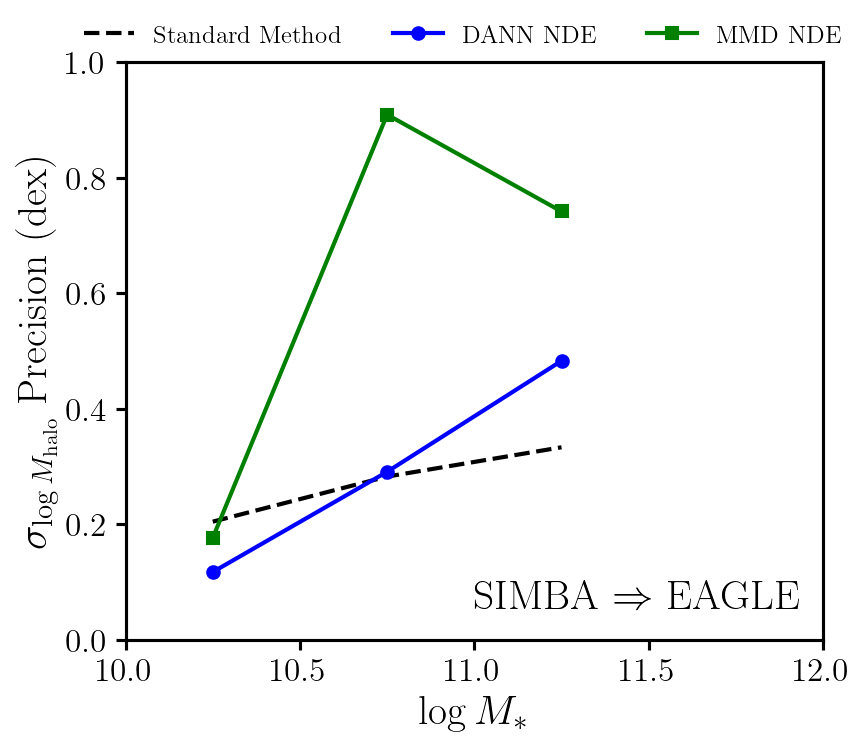

In [29]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

ax.plot(sm_bin_centers, stand_precision, label='Standard Method', lw=2, color='k', ls='--')
ax.plot(sm_bin_centers, dann_precision, label='DANN NDE', lw=2, color='blue', marker='o')
ax.plot(sm_bin_centers, mmd_precision, label='MMD NDE', lw=2, color='green', marker='s')
ax.set_xlabel(r'$\log M_*$')
ax.set_ylabel('$\sigma_{\log M_\mathrm{halo}}$ Precision (dex)')

ax.text(0.5, 0.05, r'SIMBA $\Rightarrow$ EAGLE', transform=ax.transAxes, fontsize=20)

fig.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

ax.set_xlim(10, 12)
ax.set_ylim(0, 1)

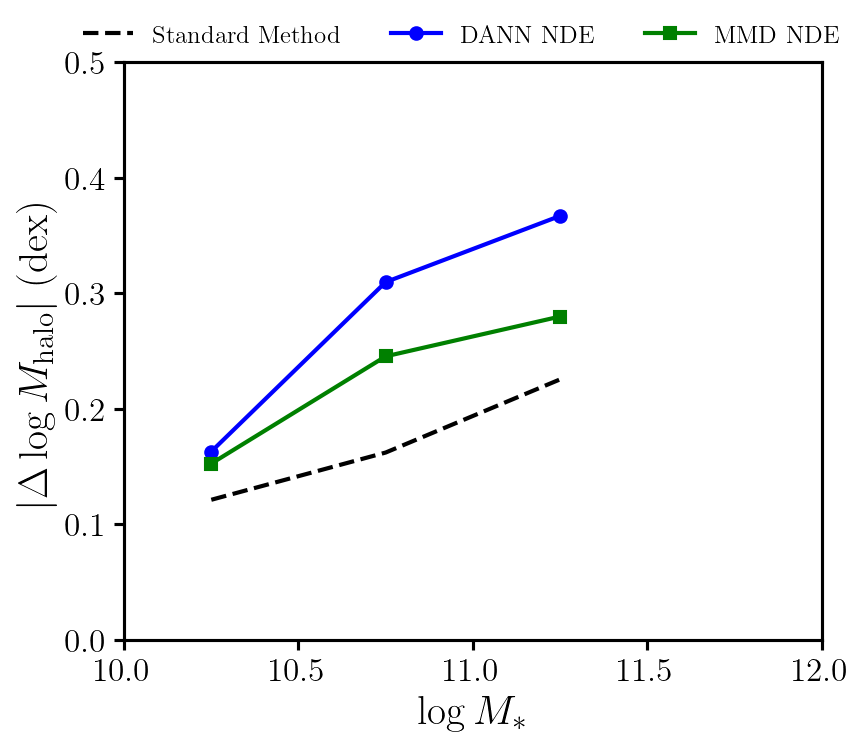

In [30]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
ax.plot(sm_bin_centers, delta_std, label='Standard Method', lw=2, color='k', ls='--')
ax.plot(sm_bin_centers, dann_delta, label='DANN NDE', lw=2, color='blue', marker='o')
ax.plot(sm_bin_centers, mmd_delta, label='MMD NDE', lw=2, color='green', marker='s')
ax.set_xlabel(r'$\log M_*$')
ax.set_ylabel(r'$|\Delta \log M_\mathrm{halo}|$ (dex)')
ax.set_xlim(10, 12)
ax.set_ylim(0, 0.5)
fig.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

0.5982664480061147 1.1706899265931108 0.621544336934169


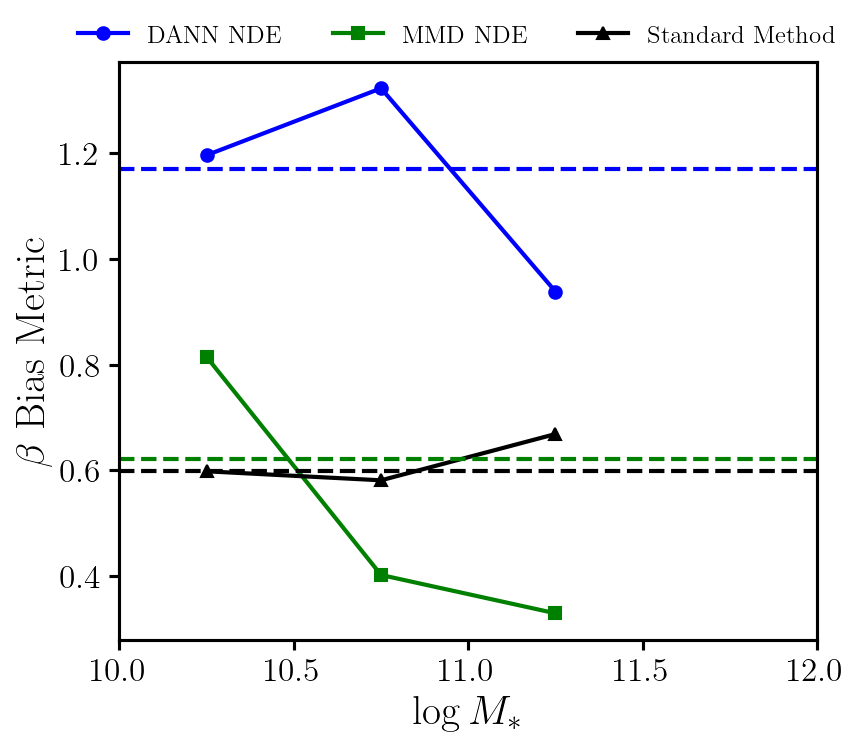

In [31]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
ax.plot(sm_bin_centers, dann_bias, label='DANN NDE', lw=2, color='blue', marker='o')
ax.plot(sm_bin_centers, mmd_bias, label='MMD NDE', lw=2, color='green', marker='s')
ax.plot(sm_bin_centers, bias_std, label='Standard Method', lw=2, color='k', marker='^')

ax.axhline(np.median(beta_ood_dann), color='blue', ls='--', lw=2)
ax.axhline(np.median(beta_ood_mmd), color='green', ls='--', lw=2)
ax.axhline(np.nanmedian(bias_std), color='k', ls='--', lw=2)
print(np.nanmedian(bias_std), np.median(beta_ood_dann), np.median(beta_ood_mmd))

ax.set_xlabel(r'$\log M_*$')
ax.set_ylabel(r'$\beta$ Bias Metric')
ax.set_xlim(10, 12)
fig.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

917 models trained
[820, 330, 469, 747, 737]


Validating NPE:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:50: UserWarning: some M* samples are below or above the Mh limit
  warnings.warn('some M* samples are below or above the Mh limit')
/Users/ng27753/Astronomy_Research/haloflow/src/haloflow/corr.py:48: UserWarning: some M* samples are below or above the M* limit
  warnings.warn('some M* samples are below or above the M* limit')


917 models trained
[820, 330, 469, 747, 737]


Validating NPE:   0%|          | 0/21 [00:00<?, ?it/s]

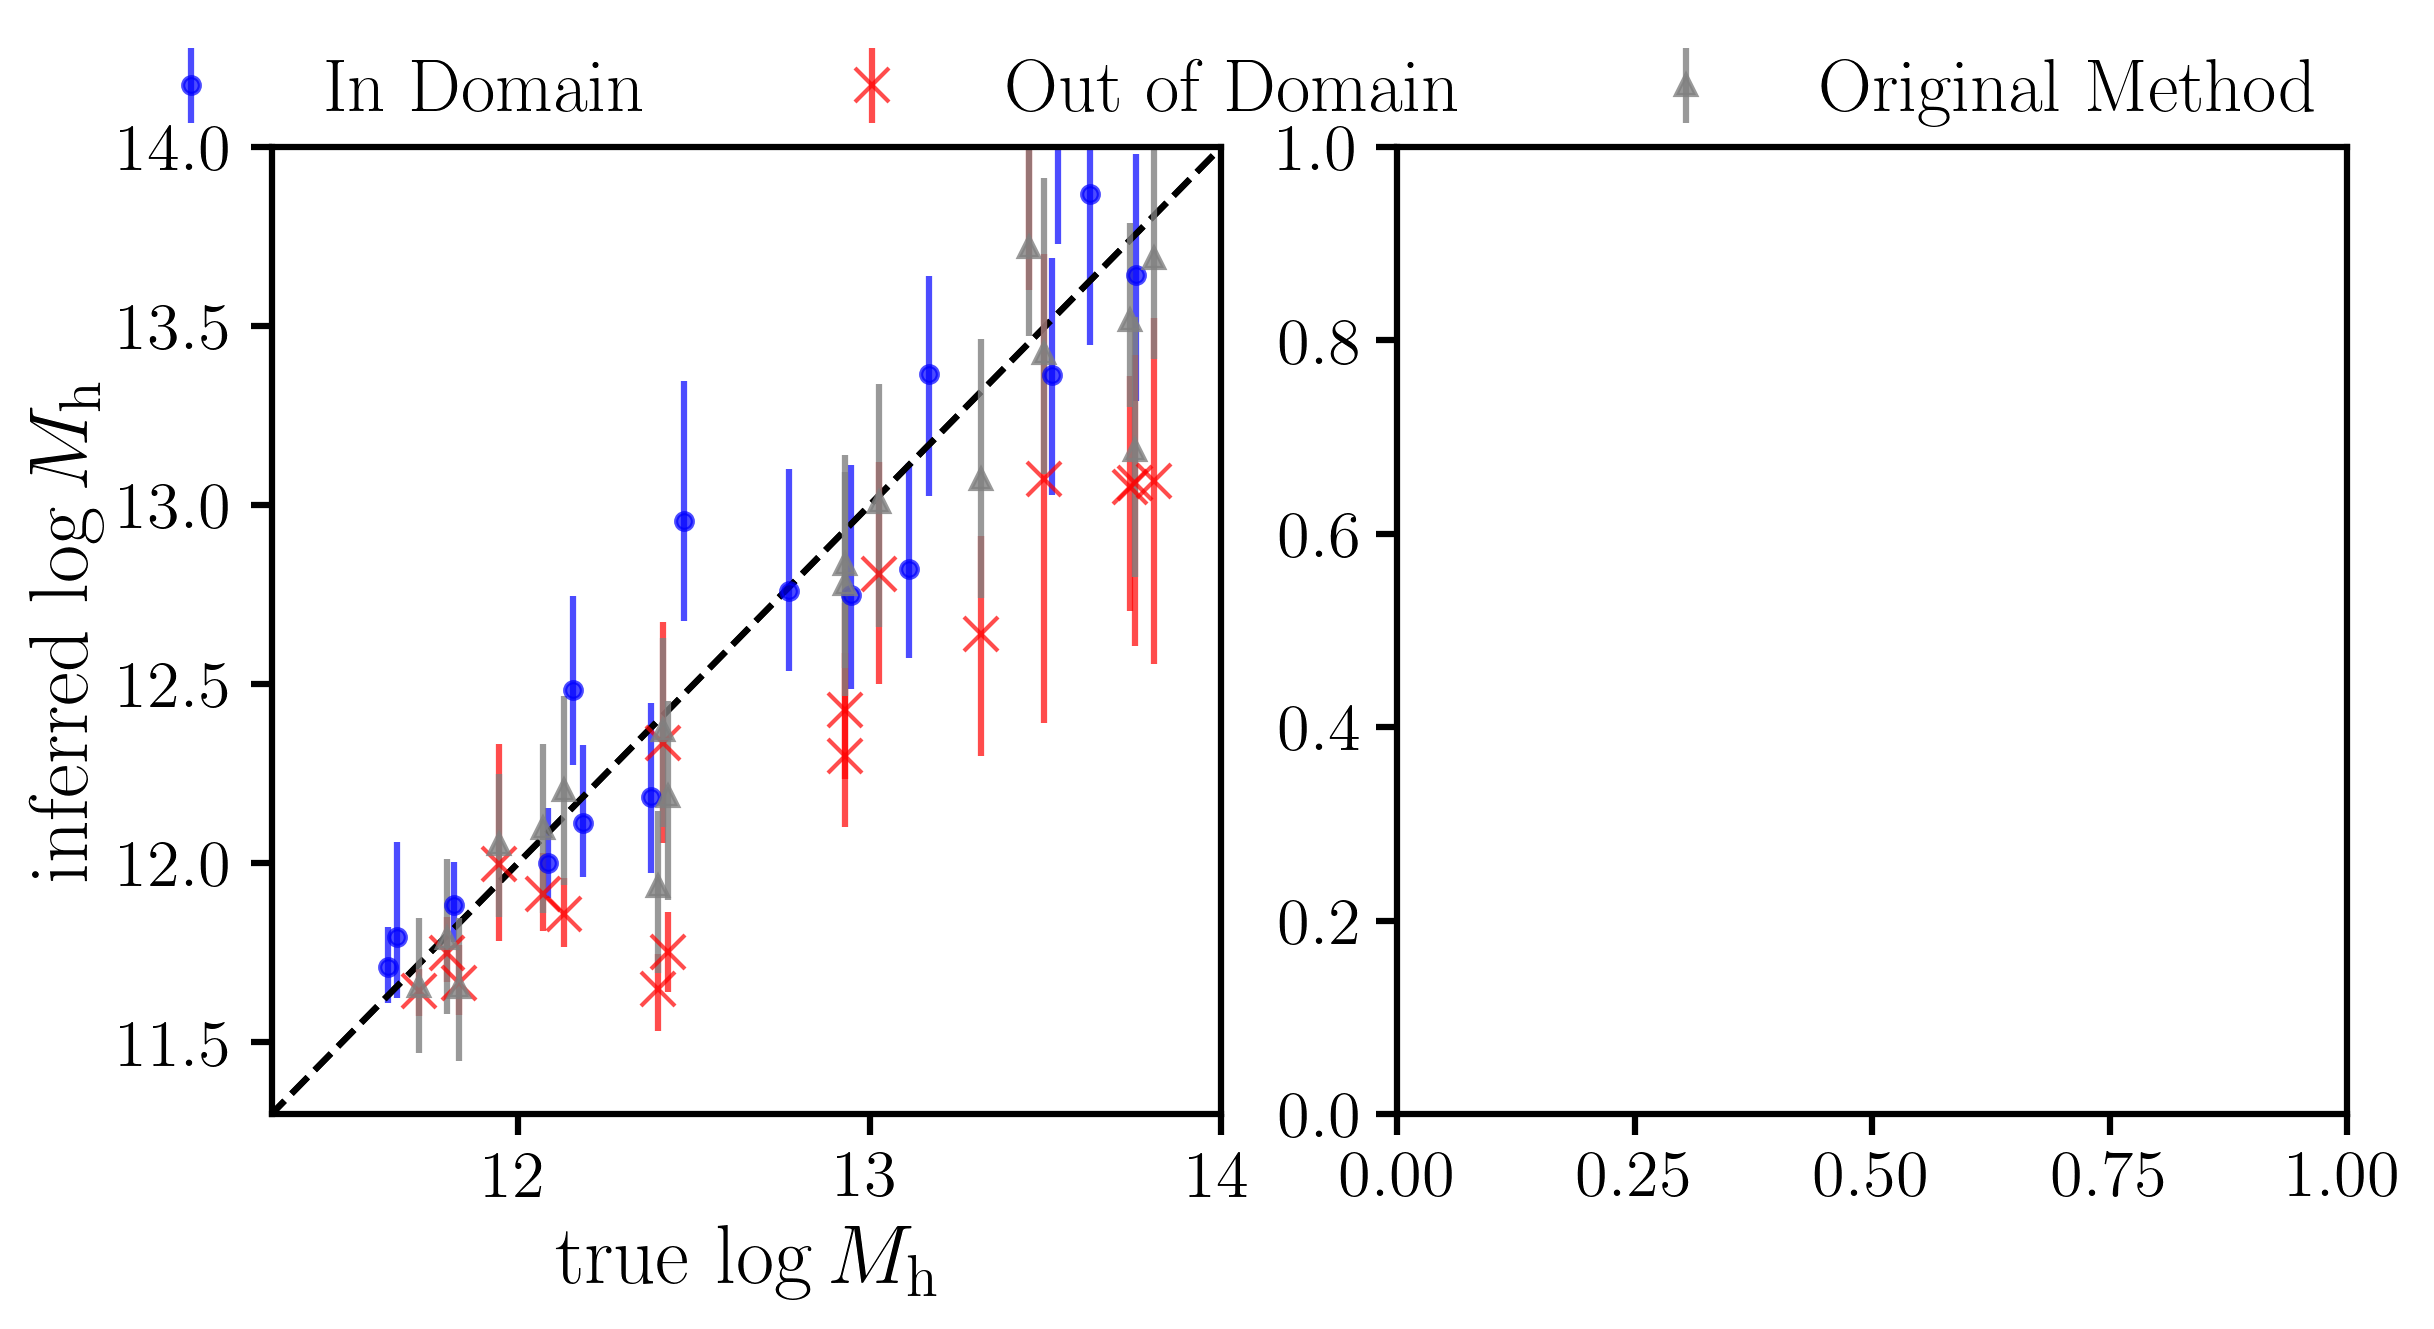

In [24]:
obs = 'mags_morph_extra'

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300, constrained_layout=True)

# Simba Train and Test
ax[0], y_true, y_nde_haloflow_simba_both = P.plot_true_pred(ax[0], 
                            train_obs=obs, 
                            dann_sim='Eagle100', 
                            npe_train_sim='Simba100', 
                            test_obs=obs, 
                            test_sim='Simba100', 
                            device='cpu', 
                            fmt='.b', 
                            use_weights=True,
                            data_dir='../../data/hf2/npe/',
                            mass='halo',
                            train_samples=P.get_sample_indices('test', obs, 'Simba100', 3)
                            )

# Simba train and Eagle100 test
idx = P.get_sample_indices('test', obs, 'Eagle100', 3)
ax[0], y_true_dann, y_nde_haloflow_simba_tngall = P.plot_true_pred(ax[0], 
                            train_obs=obs, 
                            dann_sim='Eagle100', 
                            npe_train_sim='Simba100', 
                            test_obs=obs, 
                            test_sim='Eagle100', 
                            device='cpu', 
                            fmt='xr', 
                            use_weights=True,
                            data_dir='../../data/hf2/npe/',
                            mass='halo',
                            train_samples=idx
                            )

ax[0].errorbar(y_EAGLE[idx, 1], y_nde_Eagle_SMHR_q1[idx], xerr=None,
               yerr=[y_nde_Eagle_SMHR_q2[idx] - y_nde_Eagle_SMHR_q1[idx], y_nde_Eagle_SMHR_q1[idx]-y_nde_Eagle_SMHR_q0[idx]],
               fmt='^', ms=5, alpha=0.8, color='gray', label='TNG: Mh from SIMBA SMHR + 0.15 dex')


# # Simba100 -> Simba100
# ranks, alpha, ecp, y_nde = V.validate_npe(obs, 'Eagle100', 'Simba100', 
#                             obs, 'Simba100', 'cpu', 
#                             data_dir='../../data/hf2/npe/'
#                             )


# # Simba100 -> Eagle100
# ranks_tng, alpha_tng, ecp_tng, y_nde_tng = V.validate_npe(obs, 'Eagle100', 'Simba100', 
#                             obs, 'Eagle100', 'cpu', 
#                             data_dir='../../data/hf2/npe/'
#                             )
# P.plot_coverage([alpha, alpha_tng], [ecp, ecp_tng], [None]*2, ax=ax[1])

# # ax alpha should be red and alpha_tng should be blue
# lines = ax[1].get_lines()
# lines[1].set_color('blue')
# lines[2].set_color('red')


fig.legend(['In Domain', 'Out of Domain', 'Original Method'],  
    fontsize=18,  
    loc='upper center',  
    bbox_to_anchor=(0.5, 1.1),  
    ncol=3, 
    frameon=False
)

# fig.savefig('model_mismatch_inference.pdf', bbox_inches='tight', dpi=300)